In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(1)

In [2]:
data = pd.read_csv("data/archive/train.csv")
# data_test = pd.read_csv("data/archive/mnist_test.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)
print(m, n)

42000 785


In [5]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

In [6]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Initialize parameters


In [7]:
def init_params():
    W1 = np.random.randn(10, 784) * 0.01
    b1 = np.random.randn(10, 1)
    W2 = np.random.randn(10, 10) * 0.01
    b2 = np.random.randn(10, 1)
    return W1, b1, W2, b2

Forward Propagation

In [8]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def forward_prop_dropout(W1, b1, W2, b2, X, keep_prob=0.8):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    # adding a dropout mask
    D1 = np.random.rand(A1.shape[0], A1.shape[1]) < keep_prob
    A1 *= D1 * 2
    A1 /= keep_prob
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2, D1

Backwards Propagation

In [9]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z > 0

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def back_prop_dropout(Z1, A1, D1, Z2, A2, W2, X, Y, keep_prob=0.8):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    
    dZ1 *= D1 # dropout mask
    dZ1 /= keep_prob
    
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= (alpha * dW1)
    b1 -= alpha * db1
    W2 -= (alpha * dW2)
    b2 -= alpha * db2
    return W1, b1, W2, b2



Using gradient descent

In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

In [11]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 400, 0.1)

Iteration:  0
Accuracy:  0.09685365853658537
Iteration:  10
Accuracy:  0.143390243902439
Iteration:  20
Accuracy:  0.1801219512195122
Iteration:  30
Accuracy:  0.21582926829268292
Iteration:  40
Accuracy:  0.30009756097560975
Iteration:  50
Accuracy:  0.358
Iteration:  60
Accuracy:  0.39014634146341465
Iteration:  70
Accuracy:  0.46431707317073173
Iteration:  80
Accuracy:  0.5071707317073171
Iteration:  90
Accuracy:  0.5766829268292682
Iteration:  100
Accuracy:  0.6288536585365854
Iteration:  110
Accuracy:  0.6634146341463415
Iteration:  120
Accuracy:  0.6898780487804878
Iteration:  130
Accuracy:  0.7125853658536585
Iteration:  140
Accuracy:  0.7305853658536585
Iteration:  150
Accuracy:  0.744609756097561
Iteration:  160
Accuracy:  0.757609756097561
Iteration:  170
Accuracy:  0.7684878048780488
Iteration:  180
Accuracy:  0.7789756097560976
Iteration:  190
Accuracy:  0.7881951219512195
Iteration:  200
Accuracy:  0.7971951219512196
Iteration:  210
Accuracy:  0.8061951219512196
Iteration:

In [18]:
#  Time to test with unseen data
def test_model(X_test, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_test)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = test_model(X_dev[:, index, None], W1, b1, W2, b2)
    accuracy = get_accuracy(prediction, Y_dev)
    label = Y_dev[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    print("Accuracy: ", accuracy)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.show()



Prediction:  [4]
Label:  4
Accuracy:  0.101


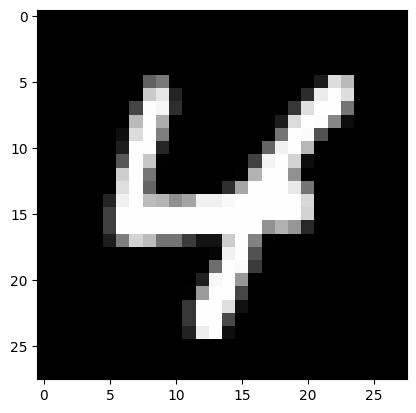

In [19]:
test_prediction(8, W1, b1, W2, b2)

In [20]:
def gradient_descent_with_dropout(X, Y, iterations, alpha, W1, b1, W2, b2):
    for i in range(iterations):
        Z1, A1, Z2, A2, D1 = forward_prop_dropout(W1, b1, W2, b2, X, keep_prob=0.8)
        dW1, db1, dW2, db2 = back_prop_dropout(Z1, A1, D1, Z2, A2, W2, X, Y, keep_prob=0.8)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

gradient_descent_with_dropout(X_train, Y_train, 400, 0.1, W1, b1, W2, b2)

Iteration:  0
Accuracy:  0.591609756097561
Iteration:  10
Accuracy:  0.6669268292682927
Iteration:  20
Accuracy:  0.6883414634146341
Iteration:  30
Accuracy:  0.6970243902439024
Iteration:  40
Accuracy:  0.7025365853658536
Iteration:  50
Accuracy:  0.7024634146341463
Iteration:  60
Accuracy:  0.7035121951219512
Iteration:  70
Accuracy:  0.7070975609756097
Iteration:  80
Accuracy:  0.7061219512195122
Iteration:  90
Accuracy:  0.7095121951219512
Iteration:  100
Accuracy:  0.7074390243902439
Iteration:  110
Accuracy:  0.7112195121951219
Iteration:  120
Accuracy:  0.7132682926829268
Iteration:  130
Accuracy:  0.7147560975609756
Iteration:  140
Accuracy:  0.717
Iteration:  150
Accuracy:  0.7162926829268292
Iteration:  160
Accuracy:  0.7159512195121951
Iteration:  170
Accuracy:  0.7181951219512195
Iteration:  180
Accuracy:  0.7187560975609756
Iteration:  190
Accuracy:  0.7198048780487805
Iteration:  200
Accuracy:  0.7200487804878049
Iteration:  210
Accuracy:  0.7196341463414634
Iteration:  2

(array([[ 0.00754903,  0.0150674 , -0.01179555, ..., -0.00273684,
         -0.01127511,  0.00686479],
        [-0.00267711,  0.00349812,  0.01038212, ...,  0.00234099,
         -0.00231874, -0.01012376],
        [-0.00617909,  0.0168716 , -0.00157799, ...,  0.00822596,
          0.00244465,  0.02179628],
        ...,
        [ 0.00269093,  0.00956348, -0.01546663, ...,  0.00105291,
          0.00131184,  0.0222932 ],
        [ 0.02047437, -0.01576264, -0.00286821, ..., -0.00204485,
          0.00543858, -0.0056653 ],
        [-0.00353286,  0.00162638, -0.01006567, ..., -0.00144388,
          0.00379796, -0.00831395]]),
 array([[ 0.20459225],
        [-1.01178467],
        [-0.02091855],
        [ 0.05373102],
        [ 1.18540966],
        [ 0.60273667],
        [-0.60156269],
        [ 1.18734988],
        [ 0.287467  ],
        [-0.84004928]]),
 array([[-0.29915726,  0.00350011, -0.69183993,  0.46761148,  0.54479002,
         -0.53006205,  0.01769844, -0.62626414, -0.46775206, -0.012

In [21]:
# Train from scratch: Dropout with new weights

def gradient_descent_with_dropout(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, D1 = forward_prop_dropout(W1, b1, W2, b2, X, keep_prob=0.8)
        dW1, db1, dW2, db2 = back_prop_dropout(Z1, A1, D1, Z2, A2, W2, X, Y, keep_prob=0.8)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

gradient_descent_with_dropout(X_train, Y_train, 400, 0.1)

Iteration:  0
Accuracy:  0.09034146341463414
Iteration:  10
Accuracy:  0.11365853658536586
Iteration:  20
Accuracy:  0.1218780487804878
Iteration:  30
Accuracy:  0.13546341463414635
Iteration:  40
Accuracy:  0.16746341463414635
Iteration:  50
Accuracy:  0.24326829268292682
Iteration:  60
Accuracy:  0.31041463414634146
Iteration:  70
Accuracy:  0.3513170731707317
Iteration:  80
Accuracy:  0.3728292682926829
Iteration:  90
Accuracy:  0.3928536585365854
Iteration:  100
Accuracy:  0.40619512195121954
Iteration:  110
Accuracy:  0.4174390243902439
Iteration:  120
Accuracy:  0.4317560975609756
Iteration:  130
Accuracy:  0.4406829268292683
Iteration:  140
Accuracy:  0.4474390243902439
Iteration:  150
Accuracy:  0.4532439024390244
Iteration:  160
Accuracy:  0.45819512195121953
Iteration:  170
Accuracy:  0.4650487804878049
Iteration:  180
Accuracy:  0.4713414634146341
Iteration:  190
Accuracy:  0.47360975609756095
Iteration:  200
Accuracy:  0.4784634146341463
Iteration:  210
Accuracy:  0.4822439

(array([[-0.01460128, -0.00699567,  0.01369669, ...,  0.00629225,
          0.00574904, -0.00201252],
        [ 0.0042406 ,  0.00621533, -0.00337579, ...,  0.01938665,
         -0.00142956,  0.00755333],
        [ 0.01367273,  0.01932446, -0.00348109, ...,  0.01658779,
          0.00656346, -0.01284865],
        ...,
        [-0.01031374, -0.01229638, -0.0189527 , ...,  0.00469047,
         -0.00174553,  0.02039875],
        [ 0.00069587,  0.00216925,  0.01343421, ...,  0.02761546,
         -0.01427786, -0.00773665],
        [ 0.00436691, -0.01283851, -0.0005877 , ...,  0.01267601,
          0.00070293, -0.00261085]]),
 array([[ 1.08228225],
        [-0.68986542],
        [ 1.67387615],
        [ 1.65410953],
        [-0.54654972],
        [-0.39973247],
        [-1.81473476],
        [-0.986608  ],
        [-0.61771895],
        [ 0.7834658 ]]),
 array([[ 4.01213015e-01, -1.72711084e-03, -1.00064951e+00,
         -1.95071021e-02,  2.94597819e-03, -1.43260432e-03,
         -5.83621552e

In [ ]:
# Using batch gradient descent instead of regular gradient descent

def batch_gradient_descent_with_dropout(X, Y, iterations, alpha, batch_size, keep_prob):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]
    
    for i in range(iterations):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        for j in range(0, m, batch_size):
            X_batch = X_shuffled[:, j:j+batch_size]
            Y_batch = Y_shuffled[j:j+batch_size]
            
            Z1, A1, Z2, A2, D1 = forward_prop_dropout(W1, b1, W2, b2, X, keep_prob=0.8)
            dW1, db1, dW2, db2 = back_prop_dropout(Z1, A1, D1, Z2, A2, W2, X, Y, keep_prob=0.8)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            _, _, _, A2_full, D1 = forward_prop_dropout(W1, b1, W2, b2, X, keep_prob=0.8)
            print("Accuracy: ", get_accuracy(get_predictions(A2_full), Y))
    return W1, b1, W2, b2

W1, b1, W2, b2 = batch_gradient_descent_with_dropout(X_train, Y_train, 300, 0.1, batch_size=30, keep_prob=0.8)